# MLP: Becoming a backprop Ninja

- we will stick with mlp one more lecture, we have a pretty decent understanding of the architecture and how it works (forward pass)
    - but we need to have a better understanding of the backward pass as well
    - so, we will remove the use of loss.backward() -that uses pytorch's autograd- and implement it ourselves on the level of tensors
- understanding the backward pass is important because it doesn't just make the network learn magically, we might shoot ourselves in the foot if we don't understand its internals
    - we have to understand how it works under the hood if we are hoping to debug it and address it in the neural network

- we took some examples
    - like the flat tails of the activation functions and how they make gradients to be 0s, and therefore we don't want the logits to be saturated too much (based on our understanding of the backward pass, we addressed the issue)
    - the case of dead neurons (when the gradients are 0s for all the examples)
    - the case of exploding and vanishing gradients


- `just because pytorch and other frameworks offer autograd, it doesn't mean that it is okay for us to ignore how it works`

- benefit we get from understanding backprop
    - it is a good exercise
    - we will become better at debugging neural networks, and making sure we understand what we do
    - will make everything fully explicit, and we won't be nervous about the black box of autograd

- people in the past used to write the vectorized forward prop by hand then write the vectorized backward prop by hand as well, then use a gradient checking (numerical gradient checking) to make sure that the backward pass is correct
    - just like what i did in neural networks from scratch
- but today, people just use autograd and don't bother with the backward pass

In [217]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [218]:
words = open('makemore/names.txt').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [219]:
len(words)

32033

## Vocabulary

In [220]:
# build the vocabulary
vocab = sorted(list(set(''.join(words))))
stoi = { ch: i+1 for i, ch in enumerate(vocab) }
stoi['.'] = 0
itos = { i: ch for ch, i in stoi.items() }
vocab_size = len(stoi)
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [221]:
len(stoi)

27

## Building the dataset (mine: numericalization)

In [222]:
block_size = 3
def build_dataset(words):
    #block_size = 4 # context length: how many characters do we take to predict the next one
    Y, X = [], []
    for word in words:
        #print(word)
        context = ['.'] * block_size  + list(word) + ['.']
        for i in range(len(word) + 1):
            X.append([stoi[ch] for ch in context[i:i+block_size]]) # append at index i, i+1, i+2 (i+3 is the label, that is why it is excluded here)
            Y.append(stoi[context[i+block_size]]) # append the character i+3 as the label
            #print(''.join(context[i:i+block_size]), '->', context[i+block_size])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
# shuffle the words
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Utils

In [316]:
# will be used to compare manual gradient to pytorch's autograd
def cmp(s,dt,t):
    """
    s: the name of the variable
    dt: the result gradient of our manual backprop
    t: the tensor in pytorch, which we will access t.grad to get pytorch's backprop gradient
    """
    ex = torch.all(dt == t.grad).item()  # check if they are exatly equal
    app = torch.allclose(dt, t.grad) # check if they are approximately equal, in case of floating point issues
    maxdiff = (dt - t.grad).abs().max().item() # check the maximum different
    print(f'{s:15s}: Exact: {str(ex):5s}, Approx: {str(app):5s}, Max diff: {maxdiff}')

## The architecture and training loop

In [317]:
n_embed = 10
n_hidden = 64
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
# Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/((n_embed * block_size) ** 0.5)
B1 = torch.randn((1,n_hidden),                         generator=g) * 0.1 # just for fun, it is useless because of batch norm
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.1 # make the neural network unconfident
B2 = torch.randn(vocab_size,                       generator=g) * 0.1 
# Batch norm parameters
gamma = torch.randn((1, n_hidden),                 generator=g)
beta = torch.randn((1, n_hidden),                  generator=g)


parameters = [C, W1, B1, W2, B2, gamma, beta]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


- we changed the initialization a little bit
    - the bs were multiplied with small numbers (0.1) instead of making them 0s (we did this to expose any incorrect backpropagation implementation)
    - we used b1 despite using batchnorm (just to make sure we can canculate the gradient for it correctly)
    - mine: he should have divided W2 by the sqrt of the number of neurons in the previous layer

In [318]:
batch_size = 32
m = batch_size # a shorter variable for convenience

idx = torch.randint(0, len(x_train), (batch_size,), generator=g)
x_batch = x_train[idx]
y_batch = y_train[idx]

In [319]:
x_batch.shape, y_batch.shape

(torch.Size([32, 3]), torch.Size([32]))

In [320]:
emb = C[x_batch] # shape (m, block_size, n_embed)
embcat = emb.view(m, -1) # shape (m, block_size * n_embed)
# Linear layer 1
z1 = embcat @ W1 + B1 # shape (m, n_hidden)
# Batch norm
z1_mean_i = 1/m * z1.sum(dim=0, keepdim=True) # mean = sum(x) / n, shape (1, n_hidden)
diff = z1 - z1_mean_i # x - mean, shape (m, n_hidden)
diff_sq = diff ** 2 # (x - mean) ** 2, shape (m, n_hidden)
z1_var_i = 1/(m-1) * diff_sq.sum(dim=0,keepdim=True) # var = sum((x - mean) ** 2) / (n-1), we used n-1 which is bassel's correction, shape (1, n_hidden)
z1_std_i_inv = (z1_var_i + 1e-6) ** -0.5 # 1/sqrt(var + epsilon) = 1/std, shape (1, n_hidden)
z1_standardized = diff * z1_std_i_inv # (x - mean) / std, shape (m, n_hidden)
z1_rescaled = gamma * z1_standardized + beta # gamma * (x - mean) / std + beta, shape (m, n_hidden)
# Non-linearity
a1 = torch.tanh(z1_rescaled) # shape (m, n_hidden)
# Linear layer 2
z2 = a1 @ W2 + B2 # shape (m, vocab_size)
# Cross-entropy loss
logits_maxes = z2.max(dim=1, keepdim=True).values  # shape (m, 1), we used .values to get rid of the indices
norm_logits = z2 - logits_maxes # subtract the maximum value for each example for numerical stability, shape (m, vocab_size)
counts = norm_logits.exp() # shape (m, vocab_size)
counts_sum = counts.sum(dim=1, keepdim=True) # shape (m, 1)
counts_sum_inv = counts_sum ** -1 # shape (m, 1)
probs = counts * counts_sum_inv # probs = exp(logits) / sum(exp(logits)), shape (m, vocab_size)
logprobs = probs.log()  # shape (m, vocab_size)
loss = -logprobs[range(m), y_batch].mean() # negative log-likelihood, shape (1,)

# Backward pass
for p in parameters:
    p.grad = None
# retain the grad for all the tensors (so that we can compare the gradients)
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, 
          norm_logits, logits_maxes, z2, a1, z1_rescaled, z1_standardized,
           z1_std_i_inv, z1_var_i, diff_sq, diff, z1, z1_mean_i, embcat, emb]:
    t.retain_grad()
# backprop the loss and compute the gradients using PyTorch's autograd
loss.backward()

- the forward pass is significantly expanded than we are used to
    - we implemented cross entropy loss ourselves
    - we also broke up the implementation to a mangeable pieces, because we will go backwards and calculate the gradients for these chunks (from the bottom to the top)
    - in the calculation of variance, we divided by (m-1) instead of m, because the number of examples is small (sample variance not population variance), that is because we are dealing with mini-batches, which is a small sample from the population (the whole dataset)
        - or we could use torch.var, with the argument unbiased=True, which will divide by (m-1) instead of m
        - by the way, the paper divides by m in training and m-1 in inference, which is wrong and produces a train-test mismatch (or a bug if you may), and pytorch implementation of `BatchNorm1d` followed the paper exactly, that bug would be more of an issue if the batch size is small
- we will have d_var, for each variable above, which is the gradient of the loss w.r.t this tensor or variable

## backprop through the the whole thing manually

In [321]:
# manual backward pass
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(m), y_batch] = -1.0/m
dprobs = (1.0 / probs) * dlogprobs # local gradient * upstream,
dcounts_sum_inv = (counts * dprobs).sum(dim=1,keepdim=True)
dcounts_sum = -1.0/(counts_sum**2) * dcounts_sum_inv
# dcoutns from formula 1
dcounts = counts_sum_inv * dprobs
# dcounts from formula 2
dcounts_second_term = torch.ones_like(counts) * dcounts_sum
dcounts += dcounts_second_term
dnorm_logits = counts * dcounts
dlogits_maxes = -1.0 * dnorm_logits.sum(dim=1,keepdim=True)
# dz2 first term
dz2 = dnorm_logits.clone()
# dz2 second term
# method1
#dz2_second_term = torch.zeros_like(z2).double()
#dz2_second_term[range(m),z2.max(dim=1, keepdim=True).indices] = 1
# method 2
dz2_second_term = F.one_hot(z2.max(dim=1).indices,num_classes=z2.shape[1]).double()
dz2_second_term *= dlogits_maxes
# add the secoond term derivative
dz2 += dz2_second_term

da1 = dz2 @ W2.T
dW2 = a1.T @ dz2
dB2 = dz2.sum(dim=0)

dz1_rescaled = (1.0 - a1**2) * da1

dgamma = (dz1_rescaled * z1_standardized).sum(dim=0, keepdim=True)
dbeta = dz1_rescaled.sum(dim=0, keepdim=True)
dz1_standardized = dz1_rescaled * gamma

dz1_std_i_inv = (dz1_standardized * diff).sum(dim=0,keepdim=True)

dz1_var_i = (-0.5*(z1_var_i+1e-6)**-1.5) * dz1_std_i_inv 

ddiff_sq = torch.ones_like(diff_sq) * 1.0/(m-1) * dz1_var_i

# diff first branch derivative 
ddiff = 2.0 * diff * ddiff_sq
# second branch 
ddiff +=  z1_std_i_inv * dz1_standardized 


dz1_mean_i = -1.0 * ddiff.sum(dim=0,keepdim=True)

# dz1 first branch diff = z1 - z1_mean_i 
dz1 = 1.0 * ddiff
# second branch z1_mean_i = 1/m * z1.sum(dim=0)
dz1_second = torch.ones_like(z1) * (1/m) * dz1_mean_i
dz1 += dz1_second

dembcat = dz1 @ W1.T
dW1 = embcat.T @ dz1
dB1 = dz1.sum(dim=0,keepdim=True)
demb = dembcat.view(emb.shape)

dC = torch.zeros_like(C)
# flatten the demb and xbatch reshaped
for idx, row in zip(x_batch.view(-1),demb.view(-1,demb.shape[-1])):
    dC[idx] += row
    
    

# compare 
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logits_maxes', dlogits_maxes, logits_maxes)
cmp('z2', dz2, z2)
cmp('a1', da1, a1)
cmp('W2', dW2, W2)
cmp('B2', dB2, B2)
cmp('z1_rescaled', dz1_rescaled, z1_rescaled)
cmp('gamma', dgamma, gamma)
cmp('beta', dbeta, beta)
cmp('z1_standardized', dz1_standardized, z1_standardized)
cmp('z1_std_i_inv', dz1_std_i_inv, z1_std_i_inv)
cmp('z1_var_i', dz1_var_i, z1_var_i)
cmp('diff_sq', ddiff_sq, diff_sq)
cmp('diff', ddiff, diff)
cmp('z1_mean_i', dz1_mean_i, z1_mean_i)
cmp('z1', dz1, z1)
cmp('embcat', dembcat, embcat)
cmp('emb', demb, emb)
cmp('W1', dW1, W1)
cmp('B1', dB1, B1)
cmp('C', dC, C)

logprobs       : Exact: True , Approx: True , Max diff: 0.0
probs          : Exact: True , Approx: True , Max diff: 0.0
counts_sum_inv : Exact: True , Approx: True , Max diff: 0.0
counts_sum     : Exact: True , Approx: True , Max diff: 0.0
counts         : Exact: True , Approx: True , Max diff: 0.0
norm_logits    : Exact: True , Approx: True , Max diff: 0.0
logits_maxes   : Exact: True , Approx: True , Max diff: 0.0
z2             : Exact: True , Approx: True , Max diff: 0.0
a1             : Exact: True , Approx: True , Max diff: 0.0
W2             : Exact: True , Approx: True , Max diff: 0.0
B2             : Exact: True , Approx: True , Max diff: 0.0
z1_rescaled    : Exact: True , Approx: True , Max diff: 0.0
gamma          : Exact: True , Approx: True , Max diff: 0.0
beta           : Exact: True , Approx: True , Max diff: 0.0
z1_standardized: Exact: True , Approx: True , Max diff: 0.0
z1_std_i_inv   : Exact: True , Approx: True , Max diff: 0.0
z1_var_i       : Exact: True , Approx: T

## Explanation

- before we start, we need to state that dvar is the same shape as var
    - that is because we want to calculate the gradient of the loss w.r.t all the elements in the tensor for all the tensors in the neural network, and whatever elements contributed to the loss, they will have a value, and if other elements didn't contribute to the loss, they will have a 0 gradient 
- dlogpropbs
    - in the forward prop, shape (m, vocab_size), we took some elements (for each row, we took the index of the actual next token), then we multiplied these numbers by -1, then we took their mean
        - so if y = -x1 - x2 - x3, then dy/dx1 = -1/3, dy/dx2 = -1/3, dy/dx3 = -1/3
            - so in case of taking the mean of m elements (examples), the gradient of the mean (loss) w.r.t each element is 1/m (-1/m because we multiplied by -1)
        - since dlogpropbs is the same shape as logpropbs, we initialize it with 0s and then index to the elements that contributed to the loss and assign them -1/m

-  dprops
    - in the forward pass we took each element in probs and applied the log function, so if $y = log(x)$, then $\frac{dy}{dx} = \frac{1}{x}$
    - in out case we have $logprops = log(probs)$, so $\frac{dlogprops}{dprobs} = \frac{1}{probs}$, that is the local gradient of the log function
    - from the chain rule, $\frac{dloss}{dprobs} = \frac{dloss}{dlogprops} \times \frac{dlogprops}{dprobs}$ which is $dlogprops \times \frac{1}{probs}$
    - what this intuitively does is that if probs is high (say 1), then the local gradient is 1, then upstream gradient will pass as it is, but if probs is low (say 0.1), then the local gradient is 10, then the upstream gradient will be boosted by 10

- dcounts_sum_inv
    - notice that counts_sum_inv is of shape (m, 1), so dcounts_sum_inv will be of the same shape
    - $\text{props} = \text{counts} * \text{counts\_sum\_inv}$, so $\frac{dprops}{dcounts\_sum\_inv} = \text{counts}$, which is of shape (m, vocab_size)
    - using the chain rule, $\frac{dloss}{dcounts\_sum\_inv} = \frac{dloss}{dprops} \times \frac{dprops}{dcounts\_sum\_inv}$, which is $dprops \times counts$ and that is of shape (m, vocab_size)
    - we will sum over the vocab_size axis (dim = 1) to get the gradient of the loss w.r.t counts_sum_inv (which is of shape (m, 1))
        - mine: think of it that way, whenever we broadcast a tensor to a bigger tensor, it is like using this tensor multiple times, so the gradient will be summed for all of the copies, so we calculate the gradient w.r.t the broadcasted tensor, then sum over the axis that was broadcasted

- dcounts_sum
    - since $counts\_sum\_inv = \frac{1}{counts\_sum}$, and we know that if $y = \frac{1}{x}$, then $\frac{dy}{dx} = -\frac{1}{x^2}$. then $\frac{dcounts\_sum\_inv}{dcounts\_sum} = -\frac{1}{counts\_sum^2}$ (that is the local gradient)
    - from the chain rule, $\frac{dloss}{dcounts\_sum} = \frac{dloss}{dcounts\_sum\_inv} \times \frac{dcounts\_sum\_inv}{dcounts\_sum}$, which is $dcounts\_sum\_inv \times -\frac{1}{counts\_sum^2}$   

- dcounts
    - counts is used in 2 formulas, so it will receive gradients from 2 sources
        - $\text{props} = \text{counts} * \text{counts\_sum\_inv}$ 
        - $\text{counts\_sum} = \text{counts.sum(dim=1, keepdim=True)}$
    - forumla 1
        - since $\text{props} = \text{counts} * \text{counts\_sum\_inv}$, then $\frac{dprops}{dcounts} = \text{counts\_sum\_inv}$, which is of shape (m, 1), so we will broadcast it -to get the same tensor that was broadcasted implicitly in the forward pass- then multiply it by dprops (shape (m, vocab_size)) to get dcounts
        - we won't actually broadcast it explicitly, when we multiply it by dprops, it will be broadcasted implicitly just like in the forward pass
    - formula 2
        - $\text{counts\_sum} = \text{counts.sum(dim=1, keepdim=True)}$, so basically we are summing over the vocab_size axis, if $y = x1 + x2 + x3$, then $\frac{dy}{dx1} = 1$, $\frac{dy}{dx2} = 1$, $\frac{dy}{dx3} = 1$, so the local gradient is 1, then the upstream gradient will pass as it is
        - in other words, we know that when we sum multiple elements, the upstream gradient will be routed to all the elements that were summed, this is exactly what we will do, and the upstream gradient for each row in counts is the corresponding row in dcounts_sum
        - example $counts = \begin{bmatrix} a1 & a2 & a3 \\ b1 & b2 & b3 \end{bmatrix}$, $counts\_sum = \begin{bmatrix} a1 + a2 + a3 \\ b1 + b2 + b3 \end{bmatrix}$, $dcounts\_sum = \begin{bmatrix} da \\ db \end{bmatrix}$, then $dcounts = \begin{bmatrix} da & da & da \\ db & db & db \end{bmatrix}$

- dnorm_logits
    - in the forward pass, we have $counts = e^{norm_logits}$, since if $y = e^x$, then $\frac{dy}{dx} = e^x$ which is y itself, then $\frac{dcounts}{dnorm\_logits} = e^{norm\_logits} = counts$ 
    - from the chain rule, $\frac{dloss}{dnorm\_logits} = \frac{dloss}{dcounts} \times \frac{dcounts}{dnorm\_logits}$, which is $dcounts \times counts$

- dlogit_maxes
    - since in the forward prop $norm\_logits_{m , vocab\_size} = logits_{m , vocab\_size} - logit\_maxes_{m, 1}$, 
    - since logit_maxes was broadcasted, then -as usual- we will calculate the gradient of the loss then sum over the axis that was broadcasted
    - if $y = x - c$, then $\frac{dy}{cx} = -1$, then $\frac{norm\_logits}{dlogit\_maxes} = -1$  
    - from the chain rule, $\frac{dloss}{dlogit\_maxes} = \frac{dloss}{dnorm\_logits} \times \frac{dnorm\_logits}{dlogit\_maxes}$, which is $dnorm\_logits \times -1$, and the result will be of shape (m, vocab_size)
        - so we will sum over the vocab_size axis (dim = 1) to get the gradient of the loss w.r.t logit_maxes (which is of shape (m, 1))
    - `intuition`: we said that the only purpose of subtracting the max from the logits is to avoid numerical instability when we exponentiate the logits then calculate the probabilities
        - so, no matter what value of logit_maxes are, they are not changing the probabilities -since the probabilities with or without them is the same-, and therefore, they are not changing the loss
        - so, we expect that the gradient of the loss w.r.t logit_maxes to be 0s, and indeed that is what we get -check the code cell below- (we actually get very small numbers on the order of 1e-9) because floating point wonkiness and approximation errors
        - therefore, in the following code 
        ```python
        z2 = W2 @ a1 + b2
        logit_maxes = z2.max(dim=1, keepdim=True).values
        norm_logits = z2 - logit_maxes
        ```
        the logit maxes subtraction is not doing anything new and therefore dz2 (dlogits) should be the same as dnorm_logits, and this is also indeed what we get -check the code cell below-
- dz2
    - z2 is of shape (m, vocab_size), so dz2 will be of the same shape
    - z2 is used in 2 formulas, so it will receive gradients from 2 sources
        - $norm\_logits = z2 - logit\_maxes$
        - $logit\_maxes = z2.max(dim=1, keepdim=True)$

    - formula 1
        - $norm\_logits = z2 - logit\_maxes$, so $\frac{dnorm\_logits}{dz2} = 1$, so from the chain rule, $\frac{dloss}{dz2} = \frac{dloss}{dnorm\_logits} \times \frac{dnorm\_logits}{dz2}$, which is $dnorm\_logits \times 1$
    - formula 2
        - $logit\_maxes = z2.max(dim=1, keepdim=True)$, so basically for each row in logit_maxes, we are taking the max of the row in z2, so the backpropagation will be routed to these elements for each row in z2
        - the local gradient is 1, so the upstream gradient will pass as it is
        - so we will start with a tensor of the same shape as z2, it will be all 0s, then we will index to the max elements in each row and set the local gradient to 1
        - then we will multiply this tensor by dlogit_maxes (the 1 in each row will be multiplied by the corresponding element in dlogit_maxes)
        - we can do it another way, by taking the one hot of the max indices -will be the sme as having an array of 0s then index to the max elements and set them to 1s- then multiply it by dlogit_maxes
- da1, dW2, db2
    - a1 is of shape (m, hidden_size), so da1 will be of the same shape
    - a1 is used in $z2 = W2 @ a1 + b2$

    ![matrix multiplication](assets/matrix_mul_derivatives.png)

    we just took a small example and derived it to understand the pattern, we first expressed matrix multiplication in terms of multiplications and additions, then we derived $dL/da1$ and $dL/dW2$ and so on (with additions in between the terms because it was used in multiple paths), then we re-arranged $dL/da$ in a matrix of the same shape as a, and found that the derivative is just a matrix multiplication as well
        - so if d = a @ b, then $dL/da = dL/dd \times b^T$
    - using the same reasoning, we can derive the rest
        - so if $z = W @ a + b$, then 
            - $\frac{dl}{da} = \frac{dl}{dz} \times W^T$

            - $\frac{dl}{dW} = a^T \times \frac{dl}{dz}$

            - $\frac{dl}{db} = \frac{dl}{dz}.sum(dim=0)$
    - spoiler alert, you can infer the formulas from the shapes analysis as they have to work out

- z1_rescaled
    - z1_rescaled is of shape (m, hidden_size), so dz1_rescaled will be of the same shape
    - $a1 = tanh(z1_rescaled)$, since $y = tanh(x)$, then $\frac{dy}{dx} = 1 - y^2$, then $\frac{da_1}{dz_1\_rescaled} = 1 - a_1^2$
    - from the chain rule, $\frac{dloss}{dz1\_rescaled} = \frac{dloss}{da1} \times \frac{da1}{dz1\_rescaled}$, which is $da1 \times (1 - a1^2)$
    

- dgamma, dbeta, dz1_rescaled
    - since gamma is of shape (1, hidden_size), then dgamma will be of the same shape
        - in the forward prop we have $z1_rescaled = gamma * z1 + beta$, since it is simple element-wise multiplication, then $\frac{dz1\_rescaled}{dgamma} = z1$, then from the chain rule, $\frac{dloss}{dgamma} = \frac{dloss}{dz1\_rescaled} \times \frac{dz1\_rescaled}{dgamma}$, which is $dz1\_rescaled \times z1$
        - gamma was broadcasted for all the examples (from shape (1, hidden_size) to (m, hidden_size)), so we will take the above result, which is of shape (m, hidden_size), then sum over the examples axis (dim = 0) -replecated in the forward pass so we accumulate the gradients for all the replications-
    - as for beta -shape (1, hidden_size)-, $\frac{dz1\_rescaled}{dbeta} = 1$, 
    - then from the chain rule, $\frac{dloss}{dbeta} = \frac{dloss}{dz1\_rescaled} \times \frac{dz1\_rescaled}{dbeta}$, which is $dz1\_rescaled \times 1$
        - beta was broadcasted for all the examples (from shape (1, hidden_size) to (m, hidden_size)), so we will take the above result, which is of shape (m, hidden_size), then sum over the examples axis (dim = 0) 
    - as for dz1_rescaled, since $z1_rescaled = gamma * z1 + beta$, then $\frac{dz1\_rescaled}{dz1} = gamma$, then from the chain rule, $\frac{dloss}{dz1} = \frac{dloss}{dz1\_rescaled} \times \frac{dz1\_rescaled}{dz1}$, which is $dz1\_rescaled \times gamma$, gamma is of shape (1, hidden_size), but when we multiply it by dz1_rescaled, it will be broadcasted implicitly just like in the forward pass

- z1_std_i_inv
    - z1_std_i_inv is of shape (m, hidden_size), so dz1_std_i_inv will be of the same shape
    - $z1_standardized = diff * z1\_std\_i\_inv$, then from the chain rule, $\frac{dloss}{dz1\_std\_i\_inv} = \frac{dloss}{dz1\_standardized} \times \frac{dz1\_standardized}{dz1\_std\_i\_inv}$, which is $dz1\_standardized \times diff$ notice that the result is of shape (m, hidden_size), because $z1\_std\_i\_inv$ was broadcasted for all the examples, so we will sum over the examples axis (dim = 0) 
        - `as you can see whenever an element is broadcasted, its derivative is summed over the axis that was broadcasted`

- z1_var_i
    - z1_var_i is of shape (m, hidden_size), so dz1_var_i will be of the same shape
    - $z1\_std\_i\_inv = (z1\_var\_i + eps)^-0.5$, if $y = x^-0.5$, then $\frac{dy}{dx} = -0.5x^-1.5$, then $\frac{dz1\_std\_i\_inv}{dz1\_var\_i} = -0.5(z1\_var\_i + eps)^{-1.5}$
    - from the chain rule, $\frac{dloss}{dz1\_var\_i} = \frac{dloss}{dz1\_std\_i\_inv} \times \frac{dz1\_std\_i\_inv}{dz1\_var\_i}$, which is $dz1\_std\_i\_inv \times -0.5(z1\_var\_i + eps)^{-1.5}$

- ddiff_sq
    - diff_sq is of shape (m, hidden_size), so ddiff_sq will be of the same shape
    - in the forward pass, we have $z1\_var\_i = \frac{1}{m} \times diff\_sq.sum(dim=0)$, 
    - so the the rows were accumulated for each column and produced a row vector $z1\_var\_i$, so each upstream gradient in $dz1\_var\_i$ will be routed to the corresponding column in $diff\_sq$
        - so we will start with a tensor of the same shape as diff_sq, it will be all 1s, but we will multiply with (1/m) since we multiplied with it in the forward prop, then we will multiply that matrix by dz1_var_i (each element in $dz1\_var\_i$ will be broadcasted -routed- to the corresponding column in $diff\_sq$)
    - example $diff\_sq = \begin{bmatrix} a1 & a2 & a3 \\ b1 & b2 & b3 \end{bmatrix}$, $dz1\_var\_i = \begin{bmatrix} da & db & dc \end{bmatrix}$, then $ddiff\_sq = \begin{bmatrix} da/(m-1) & db/(m-1) & dc/(m-1) \\ da/(m-1) & db/(m-1) & dc/(m-1) \end{bmatrix}$

- diff 
    - diff is of shape (m, hidden_size), so ddiff will be of the same shape
    - it is used in 2 formulas
        - $diff_sq = diff^2$
        - $z1\_standardized = diff * z1\_std\_i\_inv$
    - formula 1
        - $diff_sq = diff^2$, so $\frac{ddiff\_sq}{ddiff} = 2 \times diff$, which is of shape (m, hidden_size)
        - from the chain rule, $\frac{dloss}{ddiff} = \frac{dloss}{ddiff\_sq} \times \frac{ddiff\_sq}{ddiff}$, which is $ddiff\_sq \times 2 \times diff$
    - formula 2
        - $z1_standardized = diff * z1\_std\_i\_inv$, so $\frac{dz1\_standardized}{ddiff} = z1\_std\_i\_inv$, which is of shape (1, hidden_size), but when we multiply it by dz1_standardized, it will be broadcasted implicitly just like in the forward pass
        - from the chain rule, $\frac{dloss}{ddiff} = \frac{dloss}{dz1\_standardized} \times \frac{dz1\_standardized}{ddiff}$, which is $dz1\_standardized \times z1\_std\_i\_inv$

- dz1_mean_i
    - z1_mean_i is of shape (1, hidden_size), so dz1_mean_i will be of the same shape
    - in the forward pass $diff = z1 - z1_mean_i$ so $\frac{ddiff}{dz1\_mean\_i} = -1$, then from the chain rule, $\frac{dloss}{dz1\_mean\_i} = \frac{dloss}{ddiff} \times \frac{ddiff}{dz1\_mean\_i}$, which is $ddiff \times -1$
        - but since the result is of shape (m, hidden_size), because z1_mean_i was broadcasted for all the examples, so we will sum the derivative coming from all examples (dim=0) so that it will be of shape (1, hidden_size)

- dz1
    - has a shape of (m, hidden_size), so dz1 will be of the same shape
    - it was used in 2 places in the forward pass
        - $diff = z1 - z1_mean_i$
        - $z1_mean_i = \frac{1}{m} \times z1.sum(dim=0)$
    - formula 1
        - $diff = z1 - z1_mean_i$, so $\frac{ddiff}{dz1} = 1$, then from the chain rule, $\frac{dloss}{dz1} = \frac{dloss}{ddiff} \times \frac{ddiff}{dz1}$, which is $ddiff \times 1$
    - formula 2
        - since we summed the rows for each column in z1, then dz1 will be routed for each column to z1, so we start with an array of ones of the same shape as z1, then multiply it with (1/m) since we multiplied with that in the forward pass, then we multiply that array with the upsteam gradient z1_mean_i (it will be broadcasted for all the rows, with different value routed for each column)
            - in other words, each column summed its rows, so the result will be routed for all the terms in that column
- demb_cat, dW1, dB1
    - $z1 = emb_cat @ W1 + B1$, which is similar to a1,W2,B2 above, i won't write it down
- emb
    - since $embcat = emb.view(m,-1)$ basically a reshaping, so the gradient of emb is the same as embcat (dembcat) but reshape it to be of the same shape as emb

- dC
    - C is the embedding matrix, of shape (vocab_size,embed_dim), we index with the word index in the vocabulary and get the corresponding embedding vector
    - since $emb = C[x\_batch]$ where x_batch is of shape (m,block_size), and contains the indices of the characters (3 characters per row), and the result emb is of shape (m,block_size,embed_dim), which is the embedding vector -instead of the scalar indices of x_batch-
    - now in the backprop we have demb of shape (m,block_size,embed_dim), that contains the derivatives of the embeddings, since we just blucked out different rows of C, then these gradients are the gradients of different rows of C
    - so we re-arrange demb to be of shape (m*block_size,embed_dim), (basically flattened the block size into individual rows), and we do the same thing to x_batch (from shape (m,block_size) to (m*block_size,1)), then we loop on the rows gradients, use the flattened x_batch to index the corresponding row in C, then accumulate the corresponding gradient in the flattened demb

- remember: a broadcast in the forward pass, means a variable reuse, therfore a sum in the backward pass
- tip: avoid tensor a = tensor b, because that makes a and b point to the same thing, we can use tensor a = b.clone()

In [229]:
# the maxes won't affect the probabilities calculated therfore won't affect the loss, therefore they are all 0s
dlogits_maxes

tensor([[ 6.9849e-10],
        [ 9.3132e-10],
        [ 9.3132e-10],
        [-4.6566e-10],
        [-2.5611e-09],
        [ 2.7940e-09],
        [ 7.4506e-09],
        [ 6.9849e-10],
        [-1.8626e-09],
        [-4.1910e-09],
        [-1.8626e-09],
        [-2.5611e-09],
        [ 2.0955e-09],
        [-5.1223e-09],
        [ 4.6566e-09],
        [ 9.3132e-10],
        [-3.7253e-09],
        [-0.0000e+00],
        [ 5.1223e-09],
        [ 1.8626e-09],
        [-1.1642e-09],
        [ 2.0955e-09],
        [-6.0536e-09],
        [ 3.9581e-09],
        [-5.5879e-09],
        [ 2.3283e-09],
        [-0.0000e+00],
        [ 4.6566e-10],
        [-2.7940e-09],
        [-4.4238e-09],
        [-1.8626e-09],
        [ 6.7521e-09]], grad_fn=<MulBackward0>)

In [230]:
torch.allclose(dz2,dnorm_logits)

True

## Backprop through the loss
- what we did above is not what we will do in practice, we said that we can use larger blocks in forward prob, as long as we can derive their backward calculation
- so, we will backpropagate through the loss function as a single block
- we can do the differentiation on the larger block, and a lot of terms cancel and simplify, and the mathematical expression we end up with is significantly shorter and easier to implement

In [231]:
# before 
# logits_maxes = z2.max(dim=1, keepdim=True).values  # shape (m, 1), we used .values to get rid of the indices
# norm_logits = z2 - logits_maxes # subtract the maximum value for each example for numerical stability, shape (m, vocab_size)
# counts = norm_logits.exp() # shape (m, vocab_size)
# counts_sum = counts.sum(dim=1, keepdim=True) # shape (m, 1)
# counts_sum_inv = counts_sum ** -1 # shape (m, 1)
# probs = counts * counts_sum_inv # probs = exp(logits) / sum(exp(logits)), shape (m, vocab_size)
# logprobs = probs.log()  # shape (m, vocab_size)
# loss = -logprobs[range(m), y_batch].mean() # negative log-likelihood, shape (1,)

loss_fast = F.cross_entropy(z2,y_batch)
print(loss_fast.item(), f"Difference: {loss_fast-loss.item()}")

3.37553071975708 Difference: 0.0


![backprop through the loss](assets/cross_entropy_loss_derivative.jpg)

- so the derivative is basically the probabilities themselves, then we index to the actual next token in the probabilities and subtract 1 from it

- but the loss above is for a single example, for multiple examples, it is also the same but we take the mean of the losses (we divide by m in the forward prob), so we will also divide by m in the backward prob (mine:because we backpropagate that mean of the losses not each loss to each example)

In [232]:
dz2_fast = probs.clone()
dz2_fast[range(m),y_batch] -= 1
dz2_fast /= m
cmp("Z2", dz2_fast,z2)

Z2             : Exact: False, Approx: True , Max diff: 7.2177499532699585e-09


- we did not get the exact same result because of floating point wonkness, but the results are very close

- logits gradients intuition

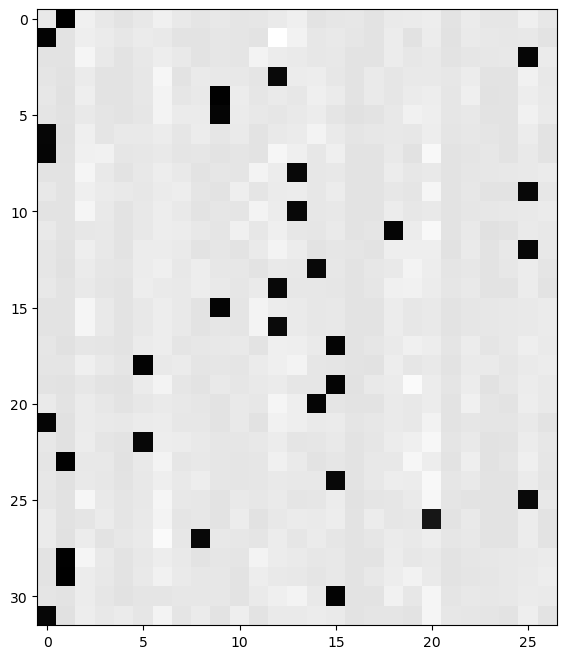

In [233]:
plt.figure(figsize=(8,8))
plt.imshow(dz2.detach(),cmap='gray')

- we know that the logits determine the probabilities, we see above the gradients of the logits, they are the probabilities themselves except for the -1 for the actual next token logit, what does that mean?
    - in the ideal case logits would be all 0s except for the actual next token logit which would be 1
        - then the gradients will be the probs themselves for the rest of the tokens (which are 0s), and probs-1 for the actual next token (which is 1-1 = 0), so in the ideal case, the gradients are all 0s, and this makes sense because we don't want to change anything in the logits in the ideal case
    - until we reach that ideal case
        - the wrong tokens logits will have probabilities > 0, and these probabilities are the gradients themselves (mine: +ve because we want to decrease them, assuming we can change z directly, z = z - lr * dz, but actually we don't decrease z directly but rather the weights and biases that produce z, that is why we further backpropagate it, but this is just so that we understand the intuition behind the sign of the gradients)
            - and the more the wrong logits are, the higher their probability -gradient- will be, so the more we will decrease them
        - the right token logit will have probability < 1, and the gradient will be this probability - 1, so it will be the difference in negative, (mine: because we want to increase it)
            - and the lower the right logit is, the lower its probability, and the higher its negative different from 1, so the more we will increase it

- so think of these gradients as a force that pushes the logits of the wrong tokens down and the right token up (with amounts that are proportional to the probabilities that came out of these logits), and the amount of push and pull is exactly equal (if we summed the logits gradients -that is the +ve terms for the wrong tokens and the -ve term for the right token- we will get 0) as we see below
    - think of the neural network now as a massive pully system or something like that, we change the weights and biases to change the logits, to pull the logits of the wrong tokens down and the right token up, and we do that for all examples
    


In [234]:
sum(dz2[0])

tensor(-6.9849e-10, grad_fn=<AddBackward0>)

## Backprop through BatchNorm
- we will backpropagate through the batchnorm as a single block

In [235]:
# before
# z1 = embcat @ W1 + B1 # shape (m, n_hidden)
# # Batch norm
# z1_mean_i = 1/m * z1.sum(dim=0, keepdim=True) # mean = sum(x) / n, shape (1, n_hidden)
# diff = z1 - z1_mean_i # x - mean, shape (m, n_hidden)
# diff_sq = diff ** 2 # (x - mean) ** 2, shape (m, n_hidden)
# z1_var_i = 1/(m-1) * diff_sq.sum(dim=0,keepdim=True) # var = sum((x - mean) ** 2) / (n-1), we used n-1 which is bassel's correction, shape (1, n_hidden)
# z1_std_i_inv = (z1_var_i + 1e-6) ** -0.5 # 1/sqrt(var + epsilon) = 1/std, shape (1, n_hidden)
# z1_standardized = diff * z1_std_i_inv # (x - mean) / std, shape (m, n_hidden)
# z1_rescaled = gamma * z1_standardized + beta # gamma * (x - mean) / std + beta, shape (m, n_hidden)

z1_rescaled_fast = gamma * ((z1 - z1.mean(dim=0,keepdim=True)) / torch.sqrt(z1.var(dim=0,keepdim=True,unbiased=True))) + beta
print("Max diff:", (z1_rescaled_fast-z1_rescaled).abs().max())

Max diff: tensor(4.2915e-06, grad_fn=<MaxBackward1>)


In [62]:
# calcualat the gradient of the loss with respect to z1
dz1 = gamma*z1_std_i_inv/m * (m*dz1_rescaled - dz1_rescaled.sum(dim=0) - m/(m-1) * z1_standardized * (dz1_rescaled * z1_standardized).sum(dim=0))
cmp("Z1",dz1,z1)

Z1             : Exact: False, Approx: True , Max diff: 9.313225746154785e-10


## Putting it all together
- we will replace loss.backwards() with our own backpropagation

In [163]:
block_size = 3
def build_dataset(words):
    #block_size = 4 # context length: how many characters do we take to predict the next one
    Y, X = [], []
    for word in words:
        #print(word)
        context = ['.'] * block_size  + list(word) + ['.']
        for i in range(len(word) + 1):
            X.append([stoi[ch] for ch in context[i:i+block_size]]) # append at index i, i+1, i+2 (i+3 is the label, that is why it is excluded here)
            Y.append(stoi[context[i+block_size]]) # append the character i+3 as the label
            #print(''.join(context[i:i+block_size]), '->', context[i+block_size])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
# shuffle the words
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [325]:
n_embed = 10
n_hidden = 64
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
# Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/((n_embed * block_size) ** 0.5)
B1 = torch.randn((1,n_hidden),                         generator=g) * 0.1 # just for fun, it is useless because of batch norm
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.1 # make the neural network unconfident
B2 = torch.randn(vocab_size,                       generator=g) * 0.1 
# Batch norm parameters
gamma = torch.randn((1, n_hidden),                 generator=g)
beta = torch.randn((1, n_hidden),                  generator=g)


parameters = [C, W1, B1, W2, B2, gamma, beta]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [346]:
steps = 10000
batch_size = 32
lossi = []
m = batch_size

for i in range(steps):
    idx = torch.randint(0, len(x_train), (batch_size,))
    x_batch = x_train[idx]
    y_batch = y_train[idx]
    emb = C[x_batch] # shape (m, block_size, n_embed)
    embcat = emb.view(m, -1) # shape (m, block_size * n_embed)
    # Linear layer 1
    z1 = embcat @ W1 + B1 # shape (m, n_hidden)
    # Batch norm
    z1_mean_i = 1/m * z1.sum(dim=0, keepdim=True) # mean = sum(x) / n, shape (1, n_hidden)
    diff = z1 - z1_mean_i # x - mean, shape (m, n_hidden)
    diff_sq = diff ** 2 # (x - mean) ** 2, shape (m, n_hidden)
    z1_var_i = 1/(m-1) * diff_sq.sum(dim=0,keepdim=True) # var = sum((x - mean) ** 2) / (n-1), we used n-1 which is bassel's correction, shape (1, n_hidden)
    z1_std_i_inv = (z1_var_i + 1e-6) ** -0.5 # 1/sqrt(var + epsilon) = 1/std, shape (1, n_hidden)
    z1_standardized = diff * z1_std_i_inv # (x - mean) / std, shape (m, n_hidden)
    z1_rescaled = gamma * z1_standardized + beta # gamma * (x - mean) / std + beta, shape (m, n_hidden)
    #z1_rescaled = gamma * ((z1 - z1.mean(dim=0,keepdim=True)) / torch.sqrt(z1.var(dim=0,keepdim=True,unbiased=True))) + beta
    
   
    # Non-linearity
    a1 = torch.tanh(z1_rescaled) # shape (m, n_hidden)
    # Linear layer 2
    z2 = a1 @ W2 + B2 # shape (m, vocab_size)
    
    # Cross-entropy loss
    # logits_maxes = z2.max(dim=1, keepdim=True).values  # shape (m, 1), we used .values to get rid of the indices
    # norm_logits = z2 - logits_maxes # subtract the maximum value for each example for numerical stability, shape (m, vocab_size)
    # counts = norm_logits.exp() # shape (m, vocab_size)
    # counts_sum = counts.sum(dim=1, keepdim=True) # shape (m, 1)
    # counts_sum_inv = counts_sum ** -1 # shape (m, 1)
    # probs = counts * counts_sum_inv # probs = exp(logits) / sum(exp(logits)), shape (m, vocab_size)
    # logprobs = probs.log()  # shape (m, vocab_size)
    # loss = -logprobs[range(m), y_batch].mean() # negative log-likelihood, shape (1,)
    loss = F.cross_entropy(z2,y_batch)

    # Backward pass
    for p in parameters:
        p.grad = None
    # retain the grad for all the tensors (so that we can compare the gradients)
    # for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, 
    #         norm_logits, logits_maxes, z2, a1, z1_rescaled, z1_standardized,
    #         z1_std_i_inv, z1_var_i, diff_sq, diff, z1, z1_mean_i, embcat, emb]:
    #     t.retain_grad()
    # backprop the loss and compute the gradients using PyTorch's autograd
    loss.backward()

    # manual backward pass
    # dlogprobs = torch.zeros_like(logprobs)
    # dlogprobs[range(m), y_batch] = -1.0/m
    # dprobs = (1.0 / probs) * dlogprobs # local gradient * upstream,
    # dcounts_sum_inv = (counts * dprobs).sum(dim=1,keepdim=True)
    # dcounts_sum = -1.0/(counts_sum**2) * dcounts_sum_inv
    # # dcoutns from formula 1
    # dcounts = counts_sum_inv * dprobs
    # # dcounts from formula 2
    # dcounts_second_term = torch.ones_like(counts) * dcounts_sum
    # dcounts += dcounts_second_term
    # dnorm_logits = counts * dcounts
    # dlogits_maxes = -1.0 * dnorm_logits.sum(dim=1,keepdim=True)
    # # dz2 first term
    # dz2 = dnorm_logits.clone()
    # # dz2 second term
    # # method1
    # #dz2_second_term = torch.zeros_like(z2).double()
    # #dz2_second_term[range(m),z2.max(dim=1, keepdim=True).indices] = 1
    # # method 2
    # dz2_second_term = F.one_hot(z2.max(dim=1).indices,num_classes=z2.shape[1]).double()
    # dz2_second_term *= dlogits_maxes
    # # add the secoond term derivative
    # dz2 += dz2_second_term
    dz2 = F.softmax(z2,dim=1)
    dz2[range(m),y_batch] -= 1
    dz2 /= m

    da1 = dz2 @ W2.T
    dW2 = a1.T @ dz2
    dB2 = dz2.sum(dim=0)

    dz1_rescaled = (1.0 - a1**2) * da1

    dgamma = (dz1_rescaled * z1_standardized).sum(dim=0, keepdim=True)
    dbeta = dz1_rescaled.sum(dim=0, keepdim=True)
    dz1_standardized = dz1_rescaled * gamma

    dz1_std_i_inv = (dz1_standardized * diff).sum(dim=0,keepdim=True)

    dz1_var_i = (-0.5*(z1_var_i+1e-6)**-1.5) * dz1_std_i_inv 

    ddiff_sq = torch.ones_like(diff_sq) * 1.0/(m-1) * dz1_var_i

    # diff first branch derivative 
    ddiff = 2.0 * diff * ddiff_sq
    # second branch 
    ddiff +=  z1_std_i_inv * dz1_standardized 


    dz1_mean_i = -1.0 * ddiff.sum(dim=0,keepdim=True)

    # dz1 first branch diff = z1 - z1_mean_i 
    dz1 = 1.0 * ddiff
    # second branch z1_mean_i = 1/m * z1.sum(dim=0)
    dz1_second = torch.ones_like(z1) * (1/m) * dz1_mean_i
    dz1 += dz1_second
    #dz1 = gamma * z1_std_i_inv /m * (m*dz1_rescaled - dz1_rescaled.sum(dim=0,keepdim=True) - m/(m-1) * z1_standardized * (dz1_rescaled * z1_standardized).sum(dim=0,keepdim=True))

    dembcat = dz1 @ W1.T
    dW1 = embcat.T @ dz1
    dB1 = dz1.sum(dim=0,keepdim=True)
    demb = dembcat.view(emb.shape)

    dC = torch.zeros_like(C)
    # flatten the demb and xbatch reshaped
    for idx, row in zip(x_batch.view(-1),demb.view(-1,demb.shape[-1])):
        dC[idx] += row

    grads = [dC, dW1, dB1, dW2, dB2, dgamma, dbeta]
    

    # step learning rate decay
    #lr = 0.1 if i < 100000 else 0.01
    lr = 0.003
    # Update the parameters using torch's autograd
    for p, grad in zip(parameters, grads):
        #p.data -= p.grad * lr # using autograd's gradient
        p.data -= grad * lr # our manual gradient
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())


Step 0.00% 2.130618095397949


In [347]:
# make sure that the our gradients match pytorch's autograd
for p, grad in zip(parameters, grads):
    cmp(str(tuple(p.shape)), grad, p)

(27, 10)       : Exact: False, Approx: True , Max diff: 2.2351741790771484e-08
(30, 64)       : Exact: False, Approx: True , Max diff: 1.1175870895385742e-08
(1, 64)        : Exact: False, Approx: True , Max diff: 4.6566128730773926e-09
(64, 27)       : Exact: False, Approx: True , Max diff: 2.2351741790771484e-08
(27,)          : Exact: False, Approx: True , Max diff: 7.450580596923828e-09
(1, 64)        : Exact: False, Approx: True , Max diff: 5.587935447692871e-09
(1, 64)        : Exact: False, Approx: True , Max diff: 6.51925802230835e-09


## Evaluate 

In [328]:
# calbirate the abtch norm at the end of the training
with torch.no_grad():
    # pass the entire training set through the network
    emb = C[x_train].view(-1, block_size*n_embed)
    z1 = emb @ W1 + B1
    # compute the mean and std of the logits
    z1_mean = z1.mean(dim=0, keepdim=True)
    z1_std = z1.std(dim=0, keepdim=True)

z1_mean.shape, z1_std.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [348]:
@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x].view(-1, block_size*n_embed)
    z1 = emb @ W1 + B1
    ## batch normalization
    z1_standardized = (z1 - z1_mean) / z1_std
    z1_rescaled = z1_standardized * gamma + beta
    a1 = torch.tanh(z1_rescaled)
    z2 = a1 @ W2 + B2
    loss = F.cross_entropy(z2, y)
    print(split, 'loss:', loss.item())

evaluate('train')
evaluate('val')

train loss: 2.155775547027588
val loss: 2.1701865196228027


## Sample from the model

In [349]:
g = torch.Generator().manual_seed(2147483647 + 4)

for _ in range(20):
    out = []
    context = [0] * block_size # we start with the '.' index, block_size times
    while True:
        emb = C[context].view(1, -1)
        z1 = emb @ W1 + B1
        z1_standardized = (z1 - z1_mean) / z1_std
        z1_rescaled = z1_standardized * gamma + beta
        a1 = torch.tanh(z1_rescaled)
        z2 = a1 @ W2 + B2
        probs = F.softmax(z2, dim=1)
        next_char = torch.multinomial(probs.view(-1), 1, generator=g).item()
        if next_char == 0:
            break
        out.append(next_char)

        context = context[1:] + [next_char]
    print(''.join(itos[i] for i in out))

jhyla
owanedk
lacer
kiyah
kylani
laj
jadylina
mai
ar
aly
alandrey
alus
walliouofben
sai
leva
brynni
sanikoi
lelyn
alis
ello
